# ICR - Identifying Age-Related Conditions
## Using Machine Learning to detect conditions with measurements of anonymous characteristics

TabPFN is a tabular prior-data fitted network for tabular data, combining approximate Bayesian inference and transformer tokenization. The paper https://arxiv.org/abs/2207.01848 presents the TabPFN in detail. I used the demo shown in the readme at https://github.com/automl/TabPFN for my model.

We start by loading our libraries and reading in our data as we did before.

In [1]:
# load libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import warnings
from sklearn.metrics import log_loss
from tabpfn import TabPFNClassifier
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')

# include all paths to data from local storage location
TRAIN_DATA = os.environ['DATAFILES_PATH'] + '/ICR_Competition/' + 'train.csv'
TEST_DATA = os.environ['DATAFILES_PATH'] + '/ICR_Competition/' + 'test.csv'
GREEKS_DATA = os.environ['DATAFILES_PATH'] + '/ICR_Competition/' + 'greeks.csv'

# load training data
train_df = pd.read_csv(TRAIN_DATA)

# allocate
X = train_df.drop(columns=['Class', 'Id'])
X = pd.get_dummies(X, drop_first=True)

y = train_df['Class'].astype(int)

### Training, tuning, and validating the TabPFN.

In [2]:
def bal_log_loss(p, y):
    ind0 = np.where(y==0)[0]
    ind1 = np.where(y==1)[0]
    
    N0 = len(ind0)
    N1 = len(ind1)
    
    y0 = (y==0).astype(int)
    y1 = y.astype(int)
    
    return (- np.sum(y0*np.log(p[:, 0]))/N0 - np.sum(y1*np.log(p[:, 1]))/N1) / 2

In [3]:
# set fold size (5 fold cv)
fold_sz = np.floor(X.shape[0] / 5).astype(int)

verbose = True

accs_total = []
blls_total = []

# loop through each fold
for i in range(5):
    
    print(f"\n*********************** FOLD #{i} ***********************\n")
    
    mask = np.ones(X.shape[0]).astype(bool)
    mask[(i*fold_sz):((i+1)*fold_sz)] = 0
    
    X_train_raw = X.loc[mask,]
    y_train_raw = y.loc[mask,]
    
    X_train_raw['EJ_B'].fillna(value=X_train_raw['EJ_B'].mode())
    X_train_raw = X_train_raw.fillna(value=X_train_raw.mean())
    
    X_train_raw = X_train_raw.to_numpy()
    y_train_raw = y_train_raw.to_numpy()
    
    X_val = X.loc[~mask,]
    y_val = y.loc[~mask,]
    
    X_val['EJ_B'].fillna(value=X.loc[mask,'EJ_B'].mode())
    X_val = X_val.fillna(value=X.loc[mask,].mean())
    
    X_val = X_val.to_numpy()
    y_val = y_val.to_numpy()

    # over sample the diagnosed patients in training set
    oversample = SMOTE(random_state=77, sampling_strategy='minority')
    X_train, y_train = oversample.fit_resample(X_train_raw, y_train_raw)

    # shuffle (in case the model choice may be impacted by ordering)
    shuff_ind = np.random.choice(len(y_train), len(y_train), replace=False)

    X_train = X_train[shuff_ind,]
    y_train = y_train[shuff_ind,]

    # set up grid of hyper-params
    parameters = {
        'N_ensemble_configurations': range(1, 12, 2)
    }

    # init lists of metrics
    accs = []
    blls = []

    # init counter
    trial = 1

    for n in parameters['N_ensemble_configurations']:

                # fit TabPFN
                classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=n)
                classifier.fit(X_train, y_train)
                
                # collect val probabilities 
                probs = classifier.predict_proba(X_val)

                # collect val accuracy 
                acc = np.mean(np.argmax(probs, 1) == y_val)
                
                # collect val balanced logarithmic loss
                bll = bal_log_loss(probs, y_val)

                # store val metrics
                accs.append(acc)
                blls.append(bll)

                if verbose:
                    print(f'Trail #{trial:2} || Using:  N_ensemble_configurations={n} || Balanced Log-Loss = {bll:.5f}')

                trial += 1
            
    accs_total.append(accs)
    blls_total.append(blls)
    



*********************** FOLD #0 ***********************

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Trail # 1 || Using:  N_ensemble_configurations=1 || Balanced Log-Loss = 0.43602
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Trail # 2 || Using:  N_ensemble_configurations=3 || Balanced Log-Loss = 0.43615
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Trail # 3 || Using:  N_ensemble_configurations=5 || Balanced Log-Loss = 0.43971
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Trail # 4 || Using:  N_ensemble_configurations=7 || Balanced Log-Loss = 0.43971
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Trail # 5 || Using:  N_ensemble_configurations=9 || Balanced Log-Loss = 0.44269
Loading model that can be used for inference only
Using a Transformer wi

Trial #1 had the lowest balanced log-loss at 0.4313578106814557.


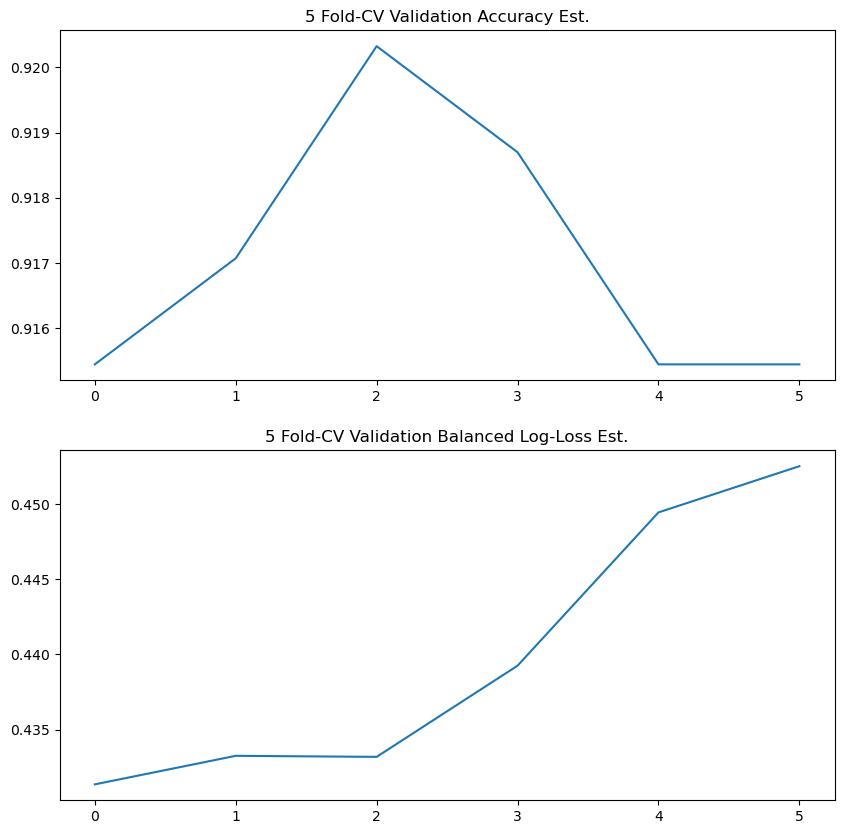

In [4]:
# store each fold's metrics in array
accs_total = np.array(accs_total)
blls_total = np.array(blls_total)


accs_CV_est = np.mean(accs_total, axis=0)
blls_CV_est = np.mean(blls_total, axis=0)

print(f'Trial #{np.argsort(blls_CV_est)[0]+1} had the lowest balanced log-loss at {np.sort(blls_CV_est)[0]}.')


figure, axis = plt.subplots(2, 1, figsize=(10, 10))
  
axis[0].plot(accs_CV_est)
axis[0].set_title("5 Fold-CV Validation Accuracy Est.")
  
axis[1].plot(blls_CV_est)
axis[1].set_title("5 Fold-CV Validation Balanced Log-Loss Est.")


plt.show()

Trial \#3 seems to have the best combination of low balanced log-loss and high accuracy across our validation sets. This corresponds to a N_ensemble_configurations=5. The final estimated balanced log-loss was 0.43136.

### Output Probabilties 

We first generate probabilities for the *official* validaiton set with tuned hyperparameters.

In [7]:
# load training data
train_df = pd.read_csv(TRAIN_DATA)

# allocate
X = train_df.drop(columns=['Class', 'Id'])
X = pd.get_dummies(X, drop_first=True)

y = train_df['Class'].astype(int)

# train-validation split 
X_train_raw, X_val, y_train_raw, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

X_val['EJ_B'].fillna(value=X_train_raw['EJ_B'].mode())
X_val = X_val.fillna(value=X_train_raw.mean())

X_train_raw['EJ_B'].fillna(value=X_train_raw['EJ_B'].mode())
X_train_raw = X_train_raw.fillna(value=X_train_raw.mean())

# over sample the diagnosed patients in training set
oversample = SMOTE(random_state=77, sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(X_train_raw, y_train_raw)

# shuffle (in case the model choice may be impacted by ordering)
shuff_ind = np.random.choice(len(y_train), len(y_train), replace=False)

X_train = X_train.iloc[shuff_ind,]
y_train = y_train.iloc[shuff_ind,]

# make uints just in case 
y_train.astype('uint8')
y_val.astype('uint8')

# fit TabPFN with optimal hyperparams 
classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=5)
classifier.fit(X_train, y_train)

# collect val probabilities 
probs = classifier.predict_proba(X_val.dropna())

# store the validation-set predictions in csv format, locally.
pd.DataFrame(probs).to_csv("val_pred_probs/tabPFN-tuned.csv", header=True, index=False)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Then we generate the probabilites for the test set (for submission).

In [8]:
# fit TabPFN with optimal hyperparams 
classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=5)

# fill NaNs
X['EJ_B'].fillna(value=X['EJ_B'].mode())
X = X.fillna(value=X.mean())

# over sample the diagnosed patients in training set
oversample = SMOTE(random_state=77, sampling_strategy='minority')
X_rs, y_rs = oversample.fit_resample(X, y)

# shuffle (in case the model choice may be impacted by ordering)
shuff_ind = np.random.choice(len(y_rs), len(y_rs), replace=False)
X_rs = X_rs.iloc[shuff_ind,]
y_rs = y_rs.iloc[shuff_ind,]

# fit xgboost model
classifier.fit(X_rs, y_rs)

# load testing data
test_df = pd.read_csv(TEST_DATA)
test_df['EJ_B'] = (test_df['EJ'] == 'B').astype('int')
X_test = test_df.drop(columns=['Id', 'EJ'])

# collect val probabilities 
probs = classifier.predict_proba(X_test)

# store the test-set predictions in csv format, locally.
pd.DataFrame(probs).to_csv("test_pred_probs/tabPFN-tuned.csv", header=True, index=False)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
